# Comparing Different CNNs on Augmented MRI Dataset
- This notebook focuses on various CNNs and compares their performance on the Augmented Dataset.
- Only the MRI Images are being here as we think that if it works better on MRI, it will automatically also work good on the CT Scans. Also, we take MRI Images here as it has a higher number of classes compared to CT Images.

In [32]:
# Loading Necessary Libraries

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
import timm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


import numpy as np
import pandas as pd

In [4]:
# Configuring Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cpu'

In [6]:
# Fixing seeds for reproducibility

import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data Preprocessing

In [7]:
# Extracting image paths

import glob
from pathlib import Path

image_paths = [] # Store image paths
labels = [] # Store corresponding labels

dataset_path = Path(r"C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI")

# Common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']

# Present Classes
image_classes = ['healthy', 'tumor-glioma', 'tumor-meningioma', 'tumor-pituitary']

# Function to get all image paths for a specific class
def get_image_files(folder_path):

    image_files = []
    for extension in image_extensions:
        image_files.extend(glob.glob(str(folder_path / "**" / extension), recursive=True))
    return image_files

# Getting all healthy images
healthy_folder = dataset_path / 'Healthy'
if healthy_folder.exists():
    healthy_images = get_image_files(healthy_folder)
    image_paths.extend(healthy_images)
    labels.extend(['healthy'] * len(healthy_images))
    print(f"Found {len(healthy_images)} Healthy images")
else:
    print(f"Folder not found: {healthy_folder}")

# Getting all tumor images
tumor_folder = dataset_path / 'Tumor'
if tumor_folder.exists():
    for type in ['glioma', 'meningioma', 'pituitary']:
        tumor_images = get_image_files(tumor_folder / type)
        image_paths.extend(tumor_images)
        labels.extend(['tumor-' + type] * len(tumor_images))
        print(f'Found {len(tumor_images)} images of type {type}')
else:
    print(f'Folder Not Found: {tumor_folder}')

print(f"\nTotal number of images: {len(image_paths)}")

print("\n First 5 images and their labels: ")
for i in range(min(5, len(image_paths))):
    print(f"{labels[i]}: {image_paths[i]}")

Found 1500 Healthy images
Found 1500 images of type glioma
Found 1500 images of type meningioma
Found 1500 images of type pituitary

Total number of images: 6000

 First 5 images and their labels: 
healthy: C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI\Healthy\healthy_aug_albu_0.jpg
healthy: C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI\Healthy\healthy_aug_albu_1.jpg
healthy: C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI\Healthy\healthy_aug_albu_10.jpg
healthy: C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI\Healthy\healthy_aug_albu_100.jpg
healthy: C:\Users\Adarsh\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1\New_Dataset\MRI\Healthy\healthy

In [8]:
# Converting to a dataframe for easier preprocessing

data_df = pd.DataFrame(zip(image_paths, labels), columns=['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,C:\Users\Adarsh\.cache\kagglehub\datasets\murt...,healthy
1,C:\Users\Adarsh\.cache\kagglehub\datasets\murt...,healthy
2,C:\Users\Adarsh\.cache\kagglehub\datasets\murt...,healthy
3,C:\Users\Adarsh\.cache\kagglehub\datasets\murt...,healthy
4,C:\Users\Adarsh\.cache\kagglehub\datasets\murt...,healthy


In [9]:
# Train Val Test Split (70-15-15)

train_df, test_df = train_test_split(
    data_df,
    test_size=0.3, # 30% test
    stratify=data_df['labels'], # keep same class proportions
    random_state=7 # for reproducibility
)

test_df, val_df = train_test_split(
    test_df,
    test_size=0.5, # 50% Validation and 50% Test(Finally 15% for both)
    stratify=test_df['labels'],
    random_state=7
)

In [10]:
# Checking for distribution in train and test datasets

print("Train Set: ")
print(train_df['labels'].value_counts(normalize=True))
print("\nTest Set: ")
print(test_df['labels'].value_counts(normalize=True))
print("\nValidation Set: ")
print(val_df['labels'].value_counts(normalize=True))

Train Set: 
labels
tumor-meningioma    0.25
tumor-glioma        0.25
tumor-pituitary     0.25
healthy             0.25
Name: proportion, dtype: float64

Test Set: 
labels
tumor-glioma        0.25
tumor-meningioma    0.25
tumor-pituitary     0.25
healthy             0.25
Name: proportion, dtype: float64

Validation Set: 
labels
tumor-meningioma    0.25
tumor-glioma        0.25
tumor-pituitary     0.25
healthy             0.25
Name: proportion, dtype: float64


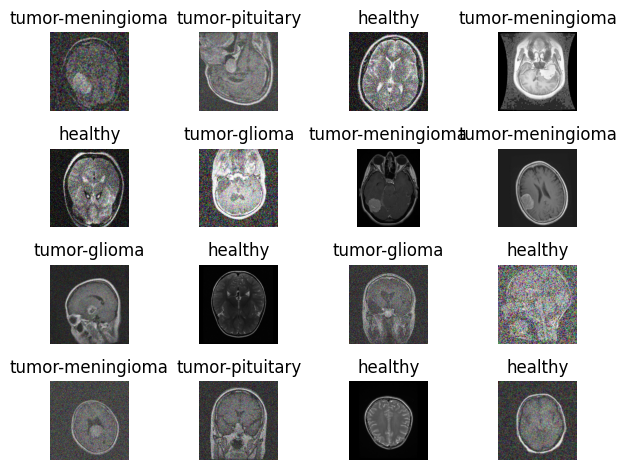

In [11]:
# Data Visualization

n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = train_df.iloc[np.random.randint(low=0, high=train_df.shape[0])]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])

plt.tight_layout()
plt.show()

In [12]:
# Encoding clases to numeric values

label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

# Model Creation, Data Loading & Hyperparameters

In [13]:
# Hyperparameters

LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 30

In [19]:
# Model info class

class Model:
    def __init__(self, name, model, weights=None, timm_model=False):
        self.name = name
        if timm_model:
            # model here is actually timm.create_model
            self.model = model(name, pretrained=True)
            self.transform = None   # timm doesn't provide built-in transforms like torchvision
        else:
            self.model = model(weights=weights)
            self.transform = weights.transforms()

# Dataset Class

class dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, index):
        img_path = self.dataframe['image_paths'].iloc[index]
        label = self.labels[index]
        image = Image.open(img_path).convert('RGB')
        if(self.transform):
            image = self.transform(image)
        return image, label

- Some models are not present in pytorch(EfficientNet, ViT, InceptionResNet).
- For those, we will use timm(Torch Image Models) from HuggingFace.

In [20]:
# Creating model objects
models = []

# VGG19
from torchvision.models import vgg19, VGG19_Weights
models.append(Model(name='vgg19',
                    model=vgg19,
                    weights=VGG19_Weights.IMAGENET1K_V1))

# Inception V3
from torchvision.models import inception_v3, Inception_V3_Weights
models.append(Model(name='inception_v3',
                    model=inception_v3,
                    weights=Inception_V3_Weights.IMAGENET1K_V1))

# ResNet50
from torchvision.models import resnet50, ResNet50_Weights
models.append(Model(name='resnet50',
                    model=resnet50,
                    weights=ResNet50_Weights.IMAGENET1K_V1))

# Wide ResNet50_2
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
models.append(Model(name='wide_resnet50_2',
                    model=wide_resnet50_2,
                    weights=Wide_ResNet50_2_Weights.IMAGENET1K_V2))

# DenseNet121
from torchvision.models import densenet121, DenseNet121_Weights
models.append(Model(name='densenet121',
                    model=densenet121,
                    weights=DenseNet121_Weights.IMAGENET1K_V1))

# DenseNet169
from torchvision.models import densenet169, DenseNet169_Weights
models.append(Model(name='densenet169',
                    model=densenet169,
                    weights=DenseNet169_Weights.IMAGENET1K_V1))

# MobileNet V2
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
models.append(Model(name='mobilenet_v2',
                    model=mobilenet_v2,
                    weights=MobileNet_V2_Weights.IMAGENET1K_V2))

# MobileNet V3 Small
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
models.append(Model(name='mobilenetv3_small',
                    model=mobilenet_v3_small,
                    weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1))

# MobileNet V3 Large
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
models.append(Model(name='mobilenetv3_large',
                    model=mobilenet_v3_large,
                    weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2))


# -------------------------------------------------------------------
# Extra models from timm (EfficientNet, ViT, InceptionResNet)
# -------------------------------------------------------------------
import timm

# EfficientNet
models.append(Model(name='efficientnet_b0',
                    model=timm.create_model,
                    timm_model=True))

# ViT
models.append(Model(name='vit_base_patch16_224',
                    model=timm.create_model,
                    timm_model=True))

# InceptionResNetV2
models.append(Model(name='inception_resnet_v2',
                    model=timm.create_model,
                    timm_model=True))


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

C:\Users\Adarsh\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Adarsh\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

C:\Users\Adarsh\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Adarsh\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

C:\Users\Adarsh\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Adarsh\.cache\huggingface\hub\models--timm--inception_resnet_v2.tf_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [22]:
import torch.nn as nn

# Function to modify model for 4 classes
def modify_model_for_classification(model_obj, num_classes=4):
    """
    Modify the classifier layer of different models to output num_classes
    Replace entire classifier with single Linear layer
    """
    model = model_obj.model
    model_name = model_obj.name

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False
    
    if 'vgg' in model_name:
        # VGG models: Replace entire classifier
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, num_classes)
        
    elif 'resnet' in model_name or 'wide_resnet' in model_name:
        # Torchvision ResNets
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
    elif 'densenet' in model_name:
        # DenseNet
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
        
    elif 'mobilenet' in model_name:
        if 'mobilenet_v2' in model_name:
            in_features = model.classifier[1].in_features
            model.classifier = nn.Linear(in_features, num_classes)
        else:
            # MobileNet V3
            in_features = None
            for layer in model.classifier:
                if isinstance(layer, nn.Linear):
                    in_features = layer.in_features
                    break
            if in_features is not None:
                model.classifier = nn.Linear(in_features, num_classes)
                
    elif model_name == 'inception_v3':
        # Inception V3 (torchvision)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        if hasattr(model, 'AuxLogits'):
            aux_in_features = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

    # ---------------- TIMM MODELS ---------------- #
    elif model_name.startswith("efficientnet"):
        # EfficientNet (timm)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif model_name.startswith("vit"):
        # Vision Transformer (timm)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)

    elif model_name.startswith("inception_resnet"):
        # InceptionResNetV2 (timm)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    # Enable gradients for the new classifier
    if hasattr(model, "classifier") and isinstance(model.classifier, nn.Module):
        for param in model.classifier.parameters():
            param.requires_grad = True
    if hasattr(model, "fc") and isinstance(model.fc, nn.Module):
        for param in model.fc.parameters():
            param.requires_grad = True
    if hasattr(model, "head") and isinstance(model.head, nn.Module):
        for param in model.head.parameters():
            param.requires_grad = True
    if hasattr(model, "AuxLogits"):
        for param in model.AuxLogits.fc.parameters():
            param.requires_grad = True
    
    model_obj.model = model
    return model_obj


In [33]:
# Display model summaries with correct input sizes
print("Model Summaries:")
print("=" * 50)

for i, model_obj in enumerate(models):
    print(f"\n{i+1}. {model_obj.name.upper()}")
    print("-" * 30)
    
    # Move model to device first
    model_obj.model = model_obj.model.to(device)
    
    # Determine correct input size based on model
    if 'inception' in model_obj.name:
        input_size = (3, 299, 299)
    else:
        input_size = (3, 224, 224)
    
    try:
        summary(model_obj.model, input_size=input_size, device=device)
    except Exception as e:
        print(f"Error generating summary for {model_obj.name}: {e}")
    
    print("\n" + "="*50)

Model Summaries:

1. VGG19
------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 5

In [ ]:
import time
from sklearn.metrics import accuracy_score

# Lists to store results for all models
results = {
    'model_names': [],
    'train_times': [],
    'val_eval_times': [],
    'final_test_times': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'final_test_accuracies': [],
    'best_epochs': [],
    'final_train_losses': [],
    'final_val_losses': [],
    'final_test_losses': [],
    'train_acc_history': [],
    'val_acc_history': [],    
    'train_loss_history': [], 
    'val_loss_history': []    
}

# Early stopping parameters
PATIENCE = 5  # Number of epochs to wait for improvement
MIN_DELTA = 0.01  # Minimum change to qualify as improvement

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, model_name, epochs=EPOCHS):
    """
    Train model with early stopping using validation set and final test evaluation
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*50}")
    
    model.train()
    
    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        epoch_start = time.time()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Handle Inception V3 auxiliary output during training
            if 'inception' in model_name and model.training:
                outputs, aux_outputs = model(images)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        train_acc = 100 * train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        val_eval_start_time = time.time()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_eval_time = time.time() - val_eval_start_time
        val_acc = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        
        epoch_time = time.time() - epoch_start
        
        print(f'Epoch [{epoch+1}/{epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        # Store metrics for each epoch
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Early stopping check based on validation accuracy
        if val_acc > best_val_acc + MIN_DELTA:
            best_val_acc = val_acc
            patience_counter = 0
            print(f'New best validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'No improvement. Patience: {patience_counter}/{PATIENCE}')
        
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    total_train_time = time.time() - start_time
    
    # Final test evaluation (only once after training)
    print(f"\n🔍 Final test evaluation for {model_name}...")
    test_eval_start_time = time.time()
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    final_test_eval_time = time.time() - test_eval_start_time
    final_test_acc = 100 * test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)
    
    print(f'Final Test Accuracy: {final_test_acc:.2f}%')
    print(f'Final Test Loss: {avg_test_loss:.4f}')
    
    return {
        'train_time': total_train_time,
        'val_eval_time': val_eval_time,  # Time for last validation epoch
        'final_test_time': final_test_eval_time,
        'best_train_acc': max(train_accuracies),
        'best_val_acc': best_val_acc,
        'final_test_acc': final_test_acc,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'final_test_loss': avg_test_loss,
        'epochs_trained': epoch + 1,
        'train_acc_history': train_accuracies,
        'val_acc_history': val_accuracies,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses
    }

# Main training loop for all models
print("Starting training for all models...")

for model_obj in models:
    name = model_obj.name
    model = model_obj.model
    transform = model_obj.transform

    print(f"\n🔄 Preparing {name}...")
    
    # Creating Datasets
    train_dataset = dataset(dataframe=train_df, transform=transform)
    val_dataset = dataset(dataframe=val_df, transform=transform)
    test_dataset = dataset(dataframe=test_df, transform=transform)

    # Creating Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Moving model to device
    model = model.to(device)

    # Setting criterion
    criterion = nn.CrossEntropyLoss()

    # Fix optimizer - different models have different classifier structures
    if 'vgg' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    elif 'resnet' in name or 'wide_resnet' in name:
        optimizer = Adam(model.fc.parameters(), lr=LEARNING_RATE)
    elif 'densenet' in name:
        optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    elif 'mobilenet' in name:
        if 'mobilenet_v2' in name:
            optimizer = Adam(model.classifier[1].parameters(), lr=LEARNING_RATE)
        else:
            # MobileNetV3
            # if hasattr(model.classifier, '__getitem__') and len(model.classifier) > 3:
            #     optimizer = Adam(model.classifier[3].parameters(), lr=LEARNING_RATE)
            # else:
            optimizer = Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    elif 'inception' in name:
        optimizer = Adam(model.fc.parameters(), lr=LEARNING_RATE)
    else:
        # Fallback
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    try:
        metrics = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, name, EPOCHS)
        
        # Store results
        results['model_names'].append(name)
        results['train_times'].append(metrics['train_time'])
        results['val_eval_times'].append(metrics['val_eval_time'])
        results['final_test_times'].append(metrics['final_test_time'])
        results['train_accuracies'].append(metrics['best_train_acc'])
        results['val_accuracies'].append(metrics['best_val_acc'])
        results['final_test_accuracies'].append(metrics['final_test_acc'])
        results['best_epochs'].append(metrics['epochs_trained'])
        results['final_train_losses'].append(metrics['final_train_loss'])
        results['final_val_losses'].append(metrics['final_val_loss'])
        results['final_test_losses'].append(metrics['final_test_loss'])
        results['train_acc_history'].append(metrics['train_acc_history'])
        results['val_acc_history'].append(metrics['val_acc_history'])
        results['train_loss_history'].append(metrics['train_loss_history'])
        results['val_loss_history'].append(metrics['val_loss_history'])
        
        print(f"✅ {name} completed successfully!")
        print(f"   Best Validation Accuracy: {metrics['best_val_acc']:.2f}%")
        print(f"   Final Test Accuracy: {metrics['final_test_acc']:.2f}%")
        print(f"   Training Time: {metrics['train_time']:.2f}s")
        print(f"   Epochs Trained: {metrics['epochs_trained']}")
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        # Store default values for failed models
        results['model_names'].append(name)
        results['train_times'].append(0.0)
        results['val_eval_times'].append(0.0)
        results['final_test_times'].append(0.0)
        results['train_accuracies'].append(0.0)
        results['val_accuracies'].append(0.0)
        results['final_test_accuracies'].append(0.0)
        results['best_epochs'].append(0)
        results['final_train_losses'].append(0.0)
        results['final_val_losses'].append(0.0)
        results['final_test_losses'].append(0.0)
        results['train_acc_history'].append([])
        results['val_acc_history'].append([])
        results['train_loss_history'].append([])
        results['val_loss_history'].append([])

print("\n🎉 All models training completed!")

# Display final results
print("\n" + "="*90)
print("FINAL RESULTS SUMMARY")
print("="*90)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('final_test_accuracies', ascending=False)

print(f"{'Model':<20} {'Test Acc':<10} {'Val Acc':<10} {'Train Acc':<10} {'Train Time':<12} {'Epochs':<8}")
print("-" * 80)

for idx, row in results_df.iterrows():
    print(f"{row['model_names']:<20} {row['final_test_accuracies']:<10.2f} {row['val_accuracies']:<10.2f} {row['train_accuracies']:<10.2f} {row['train_times']:<12.2f} {row['best_epochs']:<8}")

# Find best model based on test accuracy
best_model_idx = results_df['final_test_accuracies'].idxmax()
best_model = results_df.loc[best_model_idx]

print(f"\n🏆 Best Model: {best_model['model_names']}")
print(f"   Final Test Accuracy: {best_model['final_test_accuracies']:.2f}%")
print(f"   Best Validation Accuracy: {best_model['val_accuracies']:.2f}%")
print(f"   Best Train Accuracy: {best_model['train_accuracies']:.2f}%")
print(f"   Training Time: {best_model['train_times']:.2f}s")
print(f"   Epochs: {best_model['best_epochs']}")

# Example code to plot training curves for the best model
print(f"\n📊 Plotting training curves for {best_model['model_names']}...")

best_idx = results_df.index[results_df['model_names'] == best_model['model_names']].tolist()[0]

plt.figure(figsize=(15, 5))

# Plot accuracies
plt.subplot(1, 3, 1)
epochs_range = range(1, len(results['train_acc_history'][best_idx]) + 1)
plt.plot(epochs_range, results['train_acc_history'][best_idx], 'b-', label='Train Accuracy')
plt.plot(epochs_range, results['val_acc_history'][best_idx], 'r-', label='Validation Accuracy')
plt.title(f'{best_model["model_names"]} - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot losses
plt.subplot(1, 3, 2)
plt.plot(epochs_range, results['train_loss_history'][best_idx], 'b-', label='Train Loss')
plt.plot(epochs_range, results['val_loss_history'][best_idx], 'r-', label='Validation Loss')
plt.title(f'{best_model["model_names"]} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot comparison of all models' final test accuracies
plt.subplot(1, 3, 3)
model_names = [name.replace('_', ' ').title() for name in results_df['model_names']]
plt.bar(range(len(model_names)), results_df['final_test_accuracies'])
plt.title('Model Comparison - Final Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()